In [3]:
import numpy as np 
import skimage.io as io
import keras
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# EDA

In [4]:
datapath = os.getcwd()+'/train'

In [5]:
os.getcwd()

'/home/kray/Practicum'

In [6]:
datalist = os.listdir(datapath)
len(datalist)

3

In [7]:
datalist[0]

'Type_3'

In [8]:
#Fetch the paths for images
Type_1 = glob.glob(datapath+'/Type_1/*.jpg')
Type_2 = glob.glob(datapath+'/Type_2/*.jpg')
Type_3 = glob.glob(datapath+'/Type_3/*.jpg')

In [9]:
Type_1[0]

'/home/kray/Practicum/train/Type_1/102.jpg'

In [10]:
print(len(Type_1))
print(len(Type_2))
print(len(Type_3))

249
781
450


In [11]:
im = io.imread(Type_1[0])
print(type(im),im.shape) 

<class 'numpy.ndarray'> (3264, 2448, 3)


In [12]:
# check the image dimension
for Type_1_file in Type_1[:10]:
    print(io.imread(Type_1_file).shape)

(3264, 2448, 3)
(4128, 3096, 3)
(4160, 3120, 3)
(4128, 3096, 3)
(4160, 3120, 3)
(3096, 4128, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(4128, 3096, 3)
(4128, 3096, 3)


In [13]:
# check the image dimension
for Type_2_file in Type_2[:10]:
    print(io.imread(Type_2_file).shape)

(3264, 2448, 3)
(3264, 2448, 3)
(4128, 3096, 3)
(3264, 2448, 3)
(4128, 3096, 3)
(4128, 3096, 3)
(4128, 3096, 3)
(3264, 2448, 3)
(4128, 3096, 3)
(4128, 3096, 3)


In [14]:
# check the image dimension
for Type_3_file in Type_3[:10]:
    print(io.imread(Type_3_file).shape)

(4128, 3096, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(640, 480, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(4128, 3096, 3)


In [15]:
#mean of the y column of the first 10 images
np.mean([io.imread(t).shape[0] for t in Type_1[:10]])

3772.0

In [15]:
#mean of the x column of the first 10 images
np.mean([io.imread(t).shape[1] for t in Type_1[:10]])

3009.5999999999999

In [16]:
np.mean([io.imread(t).shape[0] for t in Type_2[:10]])

3782.4000000000001

In [17]:
np.mean([io.imread(t).shape[1] for t in Type_2[:10]])

2836.8000000000002

In [18]:
np.mean([io.imread(t).shape[0] for t in Type_3[:10]])

3174.4000000000001

In [19]:
np.mean([io.imread(t).shape[1] for t in Type_3[:10]])

2380.8000000000002

In [16]:
#max pixal value
im.max()

255

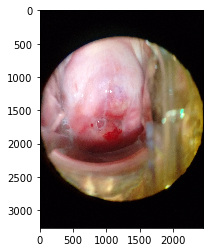

In [17]:
plt.imshow(im)

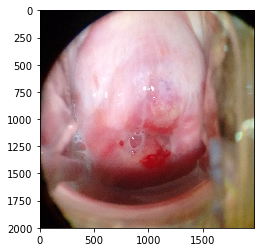

In [18]:
imc = im[500:2500, 25:2000,:] #cropping array row-> y, column-> x
plt.imshow(imc)

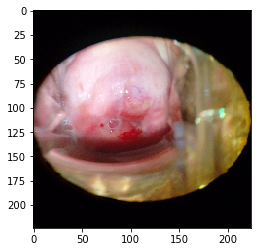

In [19]:
from skimage.transform import resize
imc = resize(im, (224,224,3))
plt.imshow(imc)

In [22]:
imc.shape

(224, 224, 3)

In [41]:
XType_1 = np.array([resize(io.imread(Type_1_file), (224,224,3)) for Type_1_file in Type_1[:10]])
XType_2 = np.array([resize(io.imread(Type_2_file), (224,224,3)) for Type_2_file in Type_2[:10]])
XType_3 = np.array([resize(io.imread(Type_3_file), (224,224,3)) for Type_3_file in Type_3[:10]])
X = np.concatenate([XType_1, XType_2, XType_3], axis=0)
y = np.concatenate([np.ones(len(Type_1)), np.ones(len(Type_2))*2, np.ones(len(Type_3))*3 ], axis=0)

SyntaxError: invalid syntax (<ipython-input-41-b7be578e482d>, line 2)

In [27]:
XType_1.shape

(10, 224, 224, 3)

In [28]:
y.shape

(1480,)

In [29]:
#the mean, max and min pixel values for each channel
for i in range(3):
    print(XType_1[:,:,:,i].max(), XType_1[:,:,:,i].min(), XType_1[:,:,:,i].mean())

1.0 0.0 0.473685660887
1.0 0.0 0.34467012369
1.0 0.0 0.378469491831


In [35]:
means = [XType_1[:,:,:,i].mean() for i in range(3)]
maxs = [XType_1[:,:,:,i].max() for i in range(3)]
mins = [XType_1[:,:,:,i].min() for i in range(3)]
Xn = np.concatenate([np.expand_dims((XType_1[:,:,:,i]-means[i])/(maxs[i]-mins[i]), axis=3) for i in range(3)], axis=3) 

In [36]:
Xn[0,:,:,0].mean()

-0.073617175864287121

In [37]:
for i in range(3):
    print(Xn[:,:,:,i].std())    

0.304197254077
0.250982131996
0.280093178749


# Build a model

In [30]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical

In [39]:
Y = to_categorical(y)
Xtr, ytr = shuffle(Xn,Y,random_state=0)

ValueError: Found input variables with inconsistent numbers of samples: [10, 1480]

In [33]:
model = Sequential()
model.add(Convolution2D(16,3,3, input_shape=(32,32,3), border_mode="same", activation='relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(2))
model.add(Activation('softmax'))
sgd = SGD(lr=0.01, decay=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['acc']) 

In [34]:
model.fit(Xtr, ytr, batch_size=32, epochs=5) #Note that nb_epoch has changed to epochs in keras 2.0

NameError: name 'Xtr' is not defined